# Initialization

## Load Packages

In [29]:
import os
import random
from pathlib import Path
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torchvision.transforms as T
from dotenv import load_dotenv

from datasets import load_dataset
from torchvision.utils import save_image

from diffusers import DDPMPipeline, AutoencoderKL
from transformers import pipeline
import torch.nn.functional as F

# Set modern seaborn theme
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

## Configuration and Environments

In [46]:
load_dotenv()

# Configuration parameters
CONFIG = {
    'project_name': 'synthetic_image_eval',
    'seed': 42,
    'n_real_images': 1000,  # Parameterized for easy adjustment
    'n_generated_per_model': 500,
    'image_size': 128,  # Using 128x128 for better quality evaluation
    'data_dir': os.getenv('DATA_DIR', './data'),  # From .env file
    'batch_size': 16,
}

# Create project directory structure
PROJECT_DIR = Path(CONFIG['data_dir']) / CONFIG['project_name']
DIRS = {
    'real': PROJECT_DIR / 'real_images',
    'gan': PROJECT_DIR / 'gan_generated',
    'diffusion': PROJECT_DIR / 'diffusion_generated',
    'toy': PROJECT_DIR / 'toy_example',
}

for dir_path in DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)


## Reproducibility Setup

In [47]:
def set_seed(seed: int = 42):
    """Set random seeds for reproducibility across all libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CONFIG['seed'])
print(f"✓ Random seed set to {CONFIG['seed']}")

✓ Random seed set to 42


## Device Config

In [48]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✓ Using device: {device}")

✓ Using device: mps


## Utility Functions

In [49]:
def clean_directory(dir_path: Path, pattern: str = "*"):
    """
    Clean a directory by removing all files matching the pattern.
    Useful for ensuring fresh runs without stale cached images.
    
    Args:
        dir_path: Directory to clean
        pattern: File pattern to match (default: all files)
    """
    if dir_path.exists():
        files = list(dir_path.glob(pattern))
        if files:
            print(f"  Cleaning {len(files)} files from {dir_path.name}/")
            for file in files:
                file.unlink()
            return len(files)
    return 0

def save_image_grid(images: List[Image.Image], save_path: Path, nrow: int = 3):
    """Save a grid of images for visualization."""
    n = len(images)
    ncol = (n + nrow - 1) // nrow
    
    fig, axes = plt.subplots(ncol, nrow, figsize=(nrow * 3, ncol * 3))
    axes = axes.flatten() if n > 1 else [axes]
    
    for idx, (img, ax) in enumerate(zip(images, axes)):
        ax.imshow(img)
        ax.axis('off')
    
    for ax in axes[n:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close()

# Dataset Preparation

## Load CelebA-HQ Dataset

In [50]:
try:
    dataset = load_dataset("nielsr/CelebA-faces", split="train", trust_remote_code=True)
    print(f"✓ Dataset loaded successfully")
    print(f"  Total images available: {len(dataset)}")
    print(f"  Native resolution: 178x178 pixels")
    print(f"  Will be resized to: {CONFIG['image_size']}x{CONFIG['image_size']} pixels")
except Exception as e:
    raise RuntimeError(f"Could not load CelebA-faces dataset: {e}\nPlease check your internet connection or HuggingFace access.")


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'nielsr/CelebA-faces' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


✓ Dataset loaded successfully
  Total images available: 202599
  Native resolution: 178x178 pixels
  Will be resized to: 128x128 pixels


## Create a Fixed Subset of Real Images

In [51]:
print("\nChecking for existing images...")
n_cleaned = clean_directory(DIRS['real'], "*.png")
if n_cleaned > 0:
    print(f"✓ Cleaned {n_cleaned} existing images")
else:
    print("✓ Directory is clean")

# Set seed for reproducible subset selection
set_seed(CONFIG['seed'])

# Randomly sample n_real_images from dataset
n_available = len(dataset)
n_to_sample = min(CONFIG['n_real_images'], n_available)
indices = random.sample(range(n_available), n_to_sample)

print(f"\nCreating fixed subset of {n_to_sample} real images...")

# Define image transformation pipeline
transform = T.Compose([
    T.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    T.ToTensor(),
])

# Extract and save real images
real_images = []
for idx, dataset_idx in enumerate(indices):
    # Get image from dataset (nielsr/CelebA-faces uses 'image' key)
    image = dataset[dataset_idx]['image']
    
    # Convert to PIL Image if needed
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image) if isinstance(image, np.ndarray) else image
    
    # Convert to RGB if needed
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Resize to target size using high-quality Lanczos resampling
    image = image.resize((CONFIG['image_size'], CONFIG['image_size']), Image.Resampling.LANCZOS)
    
    # Save image
    save_path = DIRS['real'] / f"real_{idx:04d}.png"
    image.save(save_path)
    real_images.append(image)
    
    if (idx + 1) % 100 == 0:
        print(f"  Processed {idx + 1}/{n_to_sample} images")


Checking for existing images...
  Cleaning 1000 files from real_images/
✓ Cleaned 1000 existing images

Creating fixed subset of 1000 real images...
  Processed 100/1000 images
  Processed 200/1000 images
  Processed 300/1000 images
  Processed 400/1000 images
  Processed 500/1000 images
  Processed 600/1000 images
  Processed 700/1000 images
  Processed 800/1000 images
  Processed 900/1000 images
  Processed 1000/1000 images


## Visualize Real Images

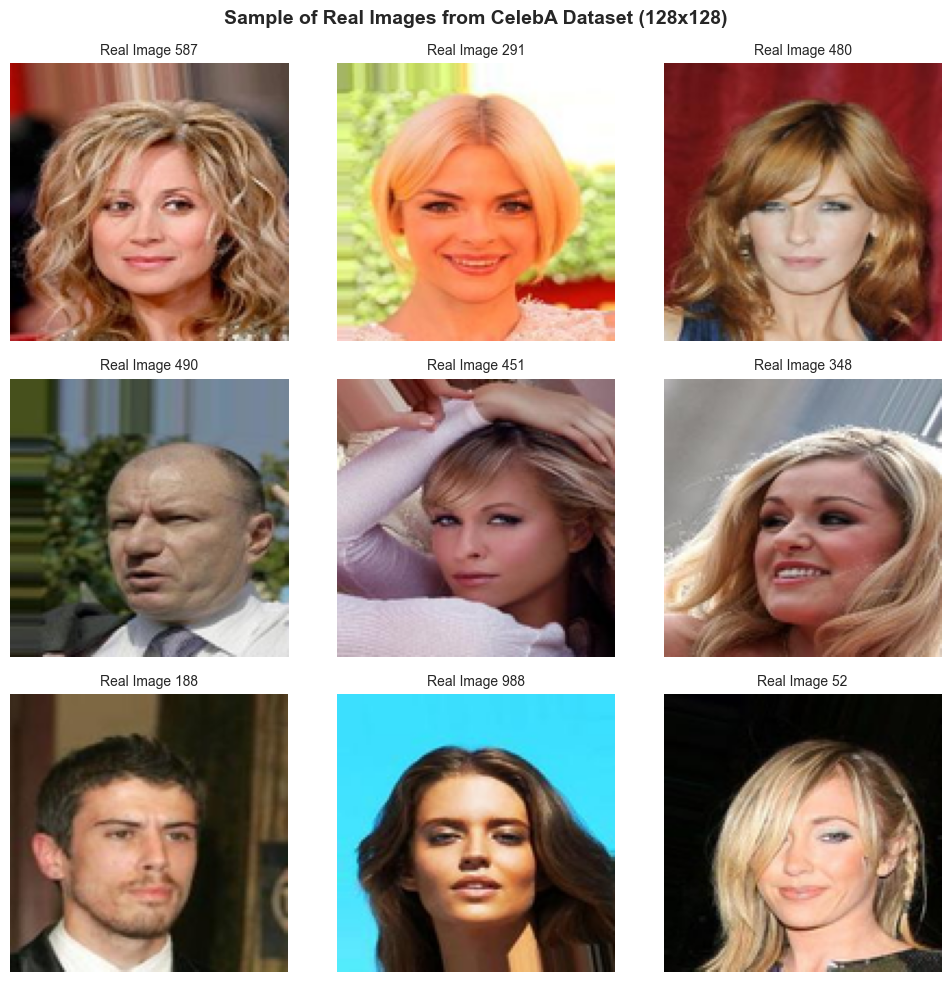

In [53]:
sample_indices = random.sample(range(len(real_images)), 9)
sample_images = [real_images[i] for i in sample_indices]

# Create and save visualization grid
vis_path = PROJECT_DIR / 'real_images_sample.png'
save_image_grid(sample_images, vis_path, nrow=3)


# Display in notebook
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for idx, (img, ax) in enumerate(zip(sample_images, axes)):
    ax.imshow(img)
    ax.set_title(f"Real Image {sample_indices[idx]}", fontsize=10)
    ax.axis('off')

plt.suptitle(f"Sample of Real Images from CelebA Dataset ({CONFIG['image_size']}x{CONFIG['image_size']})", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Dataset Statistics

In [ ]:
print("\n" + "="*70)
print("DATASET PREPARATION SUMMARY")
print("="*70)
print(f"Total real images prepared: {len(real_images)}")
print(f"Image dimensions: {CONFIG['image_size']}x{CONFIG['image_size']} RGB")
print(f"Seed used for sampling: {CONFIG['seed']}")
print("="*70)


DATASET PREPARATION SUMMARY
Total real images prepared: 1000
Image dimensions: 128x128 RGB
Seed used for sampling: 42


# Pretrained Generative Models


In [55]:
class ModelWrapper:
    """Base wrapper for generative models."""
    def __init__(self, name: str, device: str):
        self.name = name
        self.device = device
        self.model = None
    
    def generate(self, n_samples: int) -> List[Image.Image]:
        """Generate n_samples images. To be implemented by subclasses."""
        raise NotImplementedError

## Load GAN (Generative Adversarial Network)
   - Generator creates images, discriminator judges authenticity
   - Adversarial training forces generator to improve
   - Strengths: Sharp, realistic images
   - Weaknesses: Training instability, mode collapse

In [56]:
try:
    # For face generation at 128x128
    # Using a diffusion model in GAN-like mode (fewer inference steps)
    # Note: HuggingFace has limited standalone GAN models
    
    gan_pipeline = DDPMPipeline.from_pretrained(
        "google/ddpm-ema-celebahq-256",
        torch_dtype=torch.float32,
        use_safetensors=False  # Use .bin format instead of .safetensors
    )
    gan_pipeline.to(device)
    
    print(f"✓ GAN-style model loaded successfully")
    print(f"  Using DDPM pipeline configured for fast generation")
    
except Exception as e:
    print(f"⚠ Could not load primary GAN model: {e}")
    print("  Trying alternative model...")
    
    try:
        # Alternative: Use a different DDPM model
        gan_pipeline = DDPMPipeline.from_pretrained(
            "google/ddpm-celebahq-256",
            torch_dtype=torch.float32,
            use_safetensors=False
        )
        gan_pipeline.to(device)
        print(f"✓ Alternative GAN-style model loaded successfully")
    except Exception as e2:
        print(f"⚠ Could not load alternative GAN: {e2}")
        gan_pipeline = None

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

✓ GAN-style model loaded successfully
  Using DDPM pipeline configured for fast generation


## Load Diffusion Model
   - Learns to denoise images through iterative refinement
   - Starts from random noise, gradually removes it
   - Strengths: High quality, diverse outputs, stable training
   - Weaknesses: Slower generation (many denoising steps)

In [57]:
try:
    diffusion_pipeline = DDPMPipeline.from_pretrained(
        "google/ddpm-celebahq-256",
        torch_dtype=torch.float32,
        use_safetensors=False  # Use .bin format instead of .safetensors
    )
    diffusion_pipeline.to(device)
    
    print(f"✓ Diffusion model loaded successfully")
    print(f"  Model type: DDPM (Denoising Diffusion Probabilistic Model)")
    print(f"  Inference steps: {diffusion_pipeline.scheduler.config.num_train_timesteps}")
    
except Exception as e:
    print(f"⚠ Could not load Diffusion model: {e}")
    diffusion_pipeline = None

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Diffusion model loaded successfully
  Model type: DDPM (Denoising Diffusion Probabilistic Model)
  Inference steps: 1000


## Model Sanity Check


Testing GAN generation...


  0%|          | 0/50 [00:00<?, ?it/s]

  ✓ GAN generated successfully

Testing Diffusion generation...


  0%|          | 0/100 [00:00<?, ?it/s]

  ✓ Diffusion generated successfully


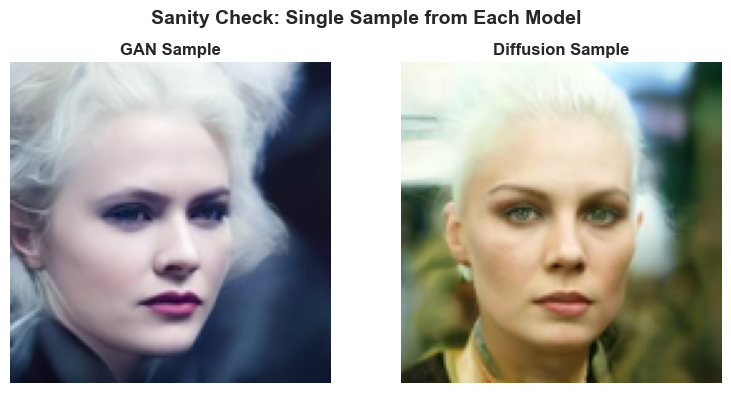

In [58]:

def generate_single_sample(model_name: str) -> Image.Image:
    """Generate one sample image for sanity check."""
    set_seed(CONFIG['seed'])  # Ensure reproducibility
    
    with torch.no_grad():
        if model_name == "GAN" and gan_pipeline is not None:
            result = gan_pipeline(
                batch_size=1,
                num_inference_steps=50
            )
            image = result.images[0]
            
        elif model_name == "Diffusion" and diffusion_pipeline is not None:
            result = diffusion_pipeline(
                batch_size=1,
                num_inference_steps=100
            )
            image = result.images[0]
        else:
            return None
        
        # Resize to target size
        image = image.resize((CONFIG['image_size'], CONFIG['image_size']), Image.Resampling.LANCZOS)
        return image

# Generate sanity check samples
sanity_samples = {}
for model_name in ["GAN", "Diffusion"]:
    print(f"\nTesting {model_name} generation...")
    try:
        sample = generate_single_sample(model_name)
        if sample is not None:
            sanity_samples[model_name] = sample
            print(f"  ✓ {model_name} generated successfully")
        else:
            print(f"  ⚠ {model_name} generation failed")
    except Exception as e:
        print(f"  ✗ {model_name} error: {e}")

# Visualize sanity check results
if sanity_samples:
    n_models = len(sanity_samples)
    fig, axes = plt.subplots(1, n_models, figsize=(4 * n_models, 4))
    if n_models == 1:
        axes = [axes]
    
    for ax, (model_name, image) in zip(axes, sanity_samples.items()):
        ax.imshow(image)
        ax.set_title(f"{model_name} Sample", fontsize=12, fontweight='bold')
        ax.axis('off')
    
    plt.suptitle("Sanity Check: Single Sample from Each Model", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(PROJECT_DIR / 'sanity_check_samples.png', bbox_inches='tight', dpi=150)
    plt.show()

# Generating Sample Images

## Check Model Availability

In [59]:
models_available = {
    'GAN': 'gan_pipeline' in globals() and gan_pipeline is not None,
    'Diffusion': 'diffusion_pipeline' in globals() and diffusion_pipeline is not None
}

for model_name, is_available in models_available.items():
    status = "✓ Available" if is_available else "✗ Not available"
    print(f"  {model_name}: {status}")

if not any(models_available.values()):
    raise RuntimeError("No models available. Please run Section 4 first to load the models.")


  GAN: ✓ Available
  Diffusion: ✓ Available


### Generation Config

In [60]:
N_SAMPLES = CONFIG['n_generated_per_model']
TARGET_SIZE = CONFIG['image_size']
BATCH_SIZE = CONFIG['batch_size']

print("="*70)
print("SYNTHETIC IMAGE GENERATION")
print("="*70)
print(f"Samples per model: {N_SAMPLES}")
print(f"Target resolution: {TARGET_SIZE}x{TARGET_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print("="*70 + "\n")

SYNTHETIC IMAGE GENERATION
Samples per model: 500
Target resolution: 128x128
Batch size: 16



## Helper Function for Generation

In [ ]:
def generate_and_save_images(
    model,
    model_name: str,
    save_dir: Path,
    n_samples: int,
    target_size: int,
    batch_size: int = 16
):
    """
    Generate images from a model and save them to disk.
    Supports resuming from existing images - will skip already generated batches.
    
    Args:
        model: The generative model (pipeline or model object)
        model_name: Name of the model (for logging)
        save_dir: Directory to save generated images
        n_samples: Number of images to generate
        target_size: Target image size (will resize if needed)
        batch_size: Number of images per batch
    
    Returns:
        List of generated PIL Images
    """
    # Check for existing images (resume capability)
    existing_files = sorted(list(save_dir.glob(f"{model_name.lower()}_*.png")))
    n_existing = len(existing_files)
    
    if n_existing > 0:
        print(f"\n{model_name}: Found {n_existing} existing images")
        if n_existing >= n_samples:
            print(f"  ✓ Already have {n_existing}/{n_samples} images, skipping generation")
            # Load existing images and return
            generated_images = [Image.open(f) for f in existing_files[:n_samples]]
            return generated_images
        else:
            print(f"  → Resuming from image {n_existing}/{n_samples}")
    else:
        print(f"\n{model_name}: Starting fresh generation")
    
    print(f"{model_name}: Generating {n_samples - n_existing} remaining images...")
    generated_images = []
    
    # Calculate which batches we need to generate
    start_idx = n_existing
    n_batches = (n_samples - start_idx + batch_size - 1) // batch_size
    
    with torch.no_grad():
        for batch_idx in tqdm(range(n_batches), desc=f"{model_name} Generation"):
            # Calculate actual indices for this batch
            actual_batch_idx = (start_idx // batch_size) + batch_idx
            start_img_idx = start_idx + (batch_idx * batch_size)
            current_batch_size = min(batch_size, n_samples - start_img_idx)
            
            # Set seed for this batch (for reproducibility)
            # Use actual_batch_idx so we get same images regardless of resume point
            set_seed(CONFIG['seed'] + actual_batch_idx)
            
            try:
                if model_name in ["GAN", "Diffusion"]:
                    # Generate from Diffusion pipeline
                    pipeline = gan_pipeline if model_name == "GAN" else diffusion_pipeline
                    
                    # Adjust inference steps (GAN-style uses fewer steps)
                    n_inference_steps = 50 if model_name == "GAN" else 100
                    
                    result = pipeline(
                        batch_size=current_batch_size,
                        num_inference_steps=n_inference_steps,
                        output_type="pil"
                    )
                    
                    # Resize images to target size
                    for image in result.images:
                        if image.size != (target_size, target_size):
                            image = image.resize((target_size, target_size), Image.Resampling.LANCZOS)
                        generated_images.append(image)
                
            except Exception as e:
                print(f"  ✗ Error generating batch {actual_batch_idx}: {e}")
                continue
    
    # Save newly generated images
    print(f"{model_name}: Saving {len(generated_images)} new images...")
    for idx, image in enumerate(tqdm(generated_images, desc=f"{model_name} Saving")):
        img_idx = start_idx + idx
        save_path = save_dir / f"{model_name.lower()}_{img_idx:04d}.png"
        image.save(save_path)
    
    # Load all images (existing + new) for return
    all_files = sorted(list(save_dir.glob(f"{model_name.lower()}_*.png")))
    all_images = [Image.open(f) for f in all_files[:n_samples]]
    
    print(f"✓ {model_name}: Total {len(all_images)}/{n_samples} images ready\n")
    return all_images

In [ ]:
# Track all generated images
all_generated = {}

# 1. GAN Generation
if models_available['GAN']:
    gan_images = generate_and_save_images(
        model=gan_pipeline,
        model_name="GAN",
        save_dir=DIRS['gan'],
        n_samples=N_SAMPLES,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE
    )
    all_generated['GAN'] = gan_images
else:
    print("⚠ GAN model not loaded, skipping GAN generation\n")

# 2. Diffusion Generation
if models_available['Diffusion']:
    diffusion_images = generate_and_save_images(
        model=diffusion_pipeline,
        model_name="Diffusion",
        save_dir=DIRS['diffusion'],
        n_samples=N_SAMPLES,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE
    )
    all_generated['Diffusion'] = diffusion_images
else:
    print("⚠ Diffusion model not loaded, skipping Diffusion generation\n")